# Нейронные сети
__Суммарное количество баллов: 10__

__Решение отправлять на `ml.course.practice@gmail.com`__

__Тема письма: `[HSE][ML][MS][HW05] <ФИ>`, где вместо `<ФИ>` указаны фамилия и имя__

Для начала вам предстоит реализовать свой собственный backpropagation и протестировать его на реальных данных, а затем научиться обучать нейронные сети при помощи библиотеки `PyTorch` и использовать это умение для классификации классического набора данных CIFAR10.

In [1]:
import numpy as np
import copy
from sklearn.datasets import make_blobs, make_moons
from typing import List, NoReturn

# Новый раздел

### Задание 1 (3 балла)
Нейронные сети состоят из слоев, поэтому для начала понадобится реализовать их. Пока нам понадобятся только три:

`Linear` - полносвязный слой, в котором `y = Wx + b`, где `y` - выход, `x` - вход, `W` - матрица весов, а `b` - смещение. 

`ReLU` - слой, соответствующий функции активации `y = max(0, x)`.

`Softmax` - слой, соответствующий функции активации [softmax](https://ru.wikipedia.org/wiki/Softmax)


#### Методы
`forward(X)` - возвращает предсказанные для `X`. `X` может быть как вектором, так и батчем

`backward(d)` - считает градиент при помощи обратного распространения ошибки. Возвращает новое значение `d`

`update(alpha)` - обновляет веса (если необходимо) с заданой скоростью обучения

In [2]:
class Module:
    """
    Абстрактный класс. Его менять не нужно.
    """
    def forward(self, x):
        raise NotImplementedError()
    
    def backward(self, d):
        raise NotImplementedError()
        
    def update(self, alpha):
        pass

In [3]:
class Linear(Module):
    """
    Линейный полносвязный слой.
    """

    def __init__(self, n_in: int, n_out: int):
        """
        Parameters
        ----------
        in_features : int
            Размер входа.
        out_features : int
            Размер выхода.

        Notes
        -----
        W и b инициализируются случайно.
        """
        stdv = 1. / np.sqrt(n_in)
        self.W = np.random.uniform(-stdv, stdv, size=(n_out, n_in))
        self.b = np.random.uniform(-stdv, stdv, size=n_out)

    def forward(self, x: np.ndarray) -> np.ndarray:
        """
        Возвращает y = Wx + b.

        Parameters
        ----------
        x : np.ndarray
            Входной вектор или батч.
            То есть, либо x вектор с in_features элементов,
            либо матрица размерности (batch_size, in_features).

        Return
        ------
        y : np.ndarray
            Выход после слоя.
            Либо вектор с out_features элементами,
            либо матрица размерности (batch_size, out_features)

        """
        self.a = x
        return self.a @ self.W.T + self.b  # aW.T + b

    def backward(self, grad: np.ndarray) -> np.ndarray:
        """
        Cчитает градиент при помощи обратного распространения ошибки.

        Parameters
        ----------
        d : np.ndarray
            Градиент.
        Return
        ------
        np.ndarray
            Новое значение градиента.
        """
        self.dW = np.sum(self.a[:, None, :] * grad[:, :, None], axis=0)  # Eq4
        self.db = np.sum(grad, axis=0)  # Eq3
        # print(f"Gradient shape is {self.dW.shape} and wights shape : {self.W.shape}")
        return grad @ self.W  # Eq2

    def update(self, alpha: float = 0.0001) -> NoReturn:
        """
        Обновляет W и b с заданной скоростью обучения.

        Parameters
        ----------
        alpha : float
            Скорость обучения.
        """
        self.W -= alpha * self.dW
        self.b -= alpha * self.db
        # print(f"Wights updated is {self.W.shape}")

In [4]:
class ReLU(Module):
    def __init__(self):
        """
        Слой, соответствующий функции активации ReLU.
        """
        pass

    def forward(self, z: np.ndarray) -> np.ndarray:
        """
        Возвращает y = max(0, x).

        Parameters
        ----------
        z : np.ndarray
            Входной вектор или батч.

        Return
        ------
        y : np.ndarray
            Выход после слоя (той же размерности, что и вход).

        """
        self.z = z
        return np.maximum(0, z)

    def backward(self, d) -> np.ndarray:
        """
        Cчитает градиент при помощи обратного распространения ошибки.

        Parameters
        ----------
        d : np.ndarray
            Градиент.
        Return
        ------
        np.ndarray
            Новое значение градиента.
        """
        grad = self.z > 0
        return d * grad
        

In [5]:
class SoftMax(Module):
    def __init__(self):
        """
        Слой, соответствующий функции активации Softmax.
        """
        pass

    def forward(self, X: np.ndarray):
        """
        Возвращает y = Softmax(x).

        Parameters
        ----------
        X : np.ndarray
            Входной вектор или батч.

        Return
        ------
        y : np.ndarray
            Выход после слоя (той же размерности, что и вход).

        """
        self.n_samples, _ = X.shape
        scores = np.subtract(X, X.max(axis=1, keepdims=True))
        self.activation = np.exp(scores) / np.sum(np.exp(scores), axis=1, keepdims=True)
        return self.activation

    def compute_loss(self, y: np.ndarray):
        """
        Cчитает loss

        Parameters
        ----------
        y : np.ndarray
            Метки классов
        Return
        ------
        float
            Значение функции потерь
        """
        self.mask = np.arange(self.n_samples), y
        self.correct_log_prob = self.activation[mask]
        self.loss = np.sum(-np.log(self.correct_log_prob)) / self.n_samples
        return self.loss

    def backward(self, y: np.ndarray):
        """
        Cчитает градиент при помощи обратного распространения ошибки.

        Parameters
        ----------
        y : np.ndarray
            True labels.
        Return
        ------
        np.ndarray
            Новое значение градиента.
        """
        self.mask = np.arange(self.n_samples), y
        self.grad = self.activation
        self.grad[self.mask] -= 1
        self.grad /= self.n_samples
        return self.grad / self.n_samples  # dCost /da * da /dz

### Задание 2 (2 балла)
Теперь сделаем саму нейронную сеть.

#### Методы
`fit(X, y)` - обучает нейронную сеть заданное число эпох. В каждой эпохе необходимо использовать [cross-entropy loss](https://ml-cheatsheet.readthedocs.io/en/latest/loss_functions.html#cross-entropy) для обучения, а так же производить обновления не по одному элементу, а используя батчи.

`predict_proba(X)` - предсказывает вероятности классов для элементов `X`

#### Параметры конструктора
`modules` - список, состоящий из ранее реализованных модулей и описывающий слои нейронной сети. В конец необходимо добавить `Softmax`

`epochs` - количество эпох обучения

`alpha` - скорость обучения

In [ ]:
def generate_batch(X: np.ndarray, y: np.ndarray, batch_size: int):
    """
    Parameters
    ----------
    X : np.ndarray
        Данные для обучения.
    y : np.ndarray
        Вектор меток классов для данных.
    batch_size : int
        Размер батча.
            Return
    ------
    np.ndarray
         батч
    """
    n_samples, _ = X.shape
    indices = np.arange(n_samples)
    np.random.shuffle(indices)
    for start in range(0, n_samples, batch_size):
        end = min(start + batch_size, n_samples)
        batch_idx = indices[start:end]
        yield X[batch_idx], y[batch_idx]

In [13]:
class MLPClassifier:
    def __init__(self, layers: List[Module], epochs: int = 40, alpha: float = 0.01):
        """
        Parameters
        ----------
        modules : list[Module]
            Cписок, состоящий из ранее реализованных модулей и
            описывающий слои нейронной сети.
            В конец необходимо добавить Softmax.
        epochs : int
            Количество эпох обучения
        alpha : float
            Cкорость обучения.
        """
        self.layers = layers
        self.alpha = alpha

    def fit(self, X: np.ndarray, y: np.ndarray, batch_size: int = 32) -> NoReturn:
        """
        Обучает нейронную сеть заданное число эпох.
        В каждой эпохе необходимо использовать cross-entropy loss для обучения,
        а так же производить обновления не по одному элементу, а используя батчи.

        Parameters
        ----------
        X : np.ndarray
            Данные для обучения.
        y : np.ndarray
            Вектор меток классов для данных.
        batch_size : int
            Размер батча.
        """
        self.layers.append(SoftMax())
        for epoch in range(40):
            for x_batch, y_batch in generate_batch(X, y, batch_size):
                for layer in self.layers:
                    x_batch = layer.forward(x_batch)

                output_error = y_batch
                for layer in reversed(self.layers):
                    output_error = layer.backward(output_error)

                for layer in self.layers:
                    layer.update(self.alpha)
        return self
                

    def predict_proba(self, X: np.ndarray):
        """
        Предсказывает вероятности классов для элементов X.

        Parameters
        ----------
        X : np.ndarray
            Данные для предсказания.

        Return
        ------
        np.ndarray
            Предсказанные вероятности классов для всех элементов X.
            Размерность (X.shape[0], n_classes)

        """
        for layer in self.layers:
            X = layer.forward(X)
        return X

    def predict(self, X: np.ndarray):
        """
        Предсказывает метки классов для элементов X.

        Parameters
        ----------
        X : np.ndarray
            Данные для предсказания.

        Return
        ------
        np.ndarray
            Вектор предсказанных классов

        """
        p = self.predict_proba(X)
        return np.argmax(p, axis=1)


def generate_batch(X: np.ndarray, y: np.ndarray, batch_size: int):
    """
    Обучает нейронную сеть заданное число эпох.
    В каждой эпохе необходимо использовать cross-entropy loss для обучения,
    а так же производить обновления не по одному элементу, а используя батчи.

    Parameters
    ----------
    X : np.ndarray
        Данные для обучения.
    y : np.ndarray
        Вектор меток классов для данных.
    batch_size : int
        Размер батча.
            Return
    ------
    np.ndarray
         батч
    """
    n_samples, _ = X.shape
    indices = np.arange(n_samples)
    np.random.shuffle(indices)
    for start in range(0, n_samples, batch_size):
        end = min(start + batch_size, n_samples)
        batch_idx = indices[start:end]
        yield X[batch_idx], y[batch_idx]

In [14]:
p = MLPClassifier([
    Linear(4, 64),
    ReLU(),
    Linear(64, 64),
    ReLU(),
    Linear(64, 2)
])

X = np.random.randn(50, 4)
y = np.array([(0 if x[0] > x[2]**2 or x[3]**3 > 0.5 else 1) for x in X])
p.fit(X, y)

### Задание 3 (2 балла)
Протестируем наше решение на синтетических данных. Необходимо подобрать гиперпараметры, при которых качество полученных классификаторов будет достаточным.

#### Оценка
Accuracy на первом датасете больше 0.85 - +1 балл

Accuracy на втором датасете больше 0.85 - +1 балл

In [15]:
X, y = make_moons(400, noise=0.075)
X_test, y_test = make_moons(400, noise=0.075)

best_acc = 0
for _ in range(25):
    p = MLPClassifier([Linear(2, 64), ReLU(), Linear(64, 2)], alpha=0.9)
    p.fit(X, y, batch_size=50)
    best_acc = max(np.mean(p.predict(X_test) == y_test), best_acc)
print("Accuracy", best_acc)

Accuracy 0.8775


In [16]:
X, y = make_blobs(400, 2, centers=[[0, 0], [2.5, 2.5], [-2.5, 3]])
X_test, y_test = make_blobs(400, 2, centers=[[0, 0], [2.5, 2.5], [-2.5, 3]])

best_acc = 0

for _ in range(25):
    p = MLPClassifier([Linear(2, 4), ReLU(), Linear(4, 3)], alpha=0.9)
    p.fit(X, y, batch_size=100)
    best_acc = max(np.mean(p.predict(X_test) == y_test), best_acc)
print("Accuracy", best_acc)

Accuracy 0.89


## PyTorch

Для выполнения следующего задания понадобится PyTorch. [Инструкция по установке](https://pytorch.org/get-started/locally/)

Если у вас нет GPU, то можно использовать [Google Colab](https://colab.research.google.com/)

In [18]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torch
from tqdm import tqdm
from torch import nn
import torch.nn.functional as F
import matplotlib.pyplot as plt

In [20]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

t = transforms.ToTensor()

cifar_train = datasets.CIFAR10("datasets/cifar10", download=True, train=True, transform=t)
train_loader = DataLoader(cifar_train, batch_size=1024, shuffle=True, pin_memory=torch.cuda.is_available())
cifar_test = datasets.CIFAR10("datasets/cifar10", download=True, train=False, transform=t)
test_loader = DataLoader(cifar_test, batch_size=1024, shuffle=False, pin_memory=torch.cuda.is_available())

Files already downloaded and verified
Files already downloaded and verified


### Задание 4 (3 балла)
А теперь поработам с настоящими нейронными сетями и настоящими данными. Необходимо реализовать сверточную нейронную сеть, которая будет классифицировать изображения из датасета CIFAR10. Имплементируйте класс `Model` и функцию `calculate_loss`. 

Обратите внимание, что `Model` должна считать в конце `softmax`, т.к. мы решаем задачу классификации. Соответствеено, функция `calculate_loss` считает cross-entropy.

Для успешного выполнения задания необходимо, чтобы `accuracy`, `mean precision` и `mean recall` были больше 0.5

__Можно пользоваться всем содержимым библиотеки PyTorch.__

In [21]:
class Model(nn.Module):
    def __init__(self):
        super().__init__()
        self._layers = nn.Sequential(
            
            nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, padding=1), 
            nn.LeakyReLU(0.1),

            nn.Conv2d(in_channels = 16, out_channels = 32,
                      kernel_size = 4, stride=2, padding=1), 
            nn.LeakyReLU(0.01),
            nn.Dropout(p=0.25),

            nn.Conv2d(32, 64, kernel_size=2, stride=2, padding=0), #
            nn.LeakyReLU(0.3),

            nn.Flatten(),
            nn.Linear(4096, 256),
            nn.LeakyReLU(0.1),
            nn.Dropout(0.5),
            nn.Linear(256, 10)
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self._layers(x)

def calculate_loss(X: torch.Tensor, y: torch.Tensor, model: Model):
    """
    Cчитает cross-entropy.

    Parameters
    ----------
    X : torch.Tensor
        Данные для обучения.
    y : torch.Tensor
        Метки классов.
    model : Model
        Модель, которую будем обучать.

    """
    logits = model(X)
    return nn.functional.cross_entropy(logits, y)

In [22]:
def train(model, epochs=30):
    optimizer = torch.optim.AdamW(model.parameters())
    train_losses = []
    test_losses = []
    for i in range(epochs):
        #Train
        loss_mean = 0
        elements = 0
        for X, y in iter(train_loader):
            X = X.to(device)
            y = y.to(device)
            loss = calculate_loss(X, y, model)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            loss_mean += loss.item() * len(X)
            elements += len(X)
        train_losses.append(loss_mean / elements)
        #Test
        loss_mean = 0
        elements = 0
        for X, y in iter(test_loader):
            X = X.to(device)
            y = y.to(device)
            loss = calculate_loss(X, y, model)
            loss_mean += loss.item() * len(X)
            elements += len(X)
        test_losses.append(loss_mean / elements)
        print("Epoch", i, "| Train loss", train_losses[-1], "| Test loss", test_losses[-1])
    return train_losses, test_losses

In [23]:
model = Model().to(device)
train_l, test_l = train(model)

Epoch 0 | Train loss 1.9715412448501586 | Test loss 1.7473465250015259
Epoch 1 | Train loss 1.6460583024597168 | Test loss 1.5557739782333373
Epoch 2 | Train loss 1.5075569159317017 | Test loss 1.4589485809326173
Epoch 3 | Train loss 1.4284841779327393 | Test loss 1.4078540908813477
Epoch 4 | Train loss 1.3563048844528198 | Test loss 1.337515311050415
Epoch 5 | Train loss 1.2964259609222413 | Test loss 1.3040979232788086
Epoch 6 | Train loss 1.2541438743591309 | Test loss 1.2679218170166016
Epoch 7 | Train loss 1.2164266105270385 | Test loss 1.242326043319702
Epoch 8 | Train loss 1.1688746140670776 | Test loss 1.2222015491485596
Epoch 9 | Train loss 1.1344879261398315 | Test loss 1.1995129856109619
Epoch 10 | Train loss 1.106653155555725 | Test loss 1.1815533853530884
Epoch 11 | Train loss 1.075991270942688 | Test loss 1.162681351852417
Epoch 12 | Train loss 1.044145131149292 | Test loss 1.1499019369125367
Epoch 13 | Train loss 1.0203792533111573 | Test loss 1.143628347015381
Epoch 14 

Построим график функции потерь

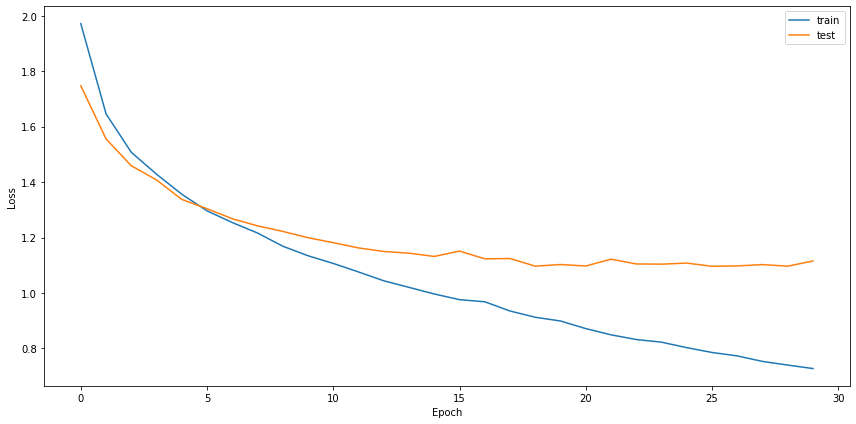

In [24]:
plt.figure(figsize=(12, 6))
plt.plot(range(len(train_l)), train_l, label="train")
plt.plot(range(len(test_l)), test_l, label="test")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.tight_layout()
plt.show()

И, наконец, посчитаем метрики

In [25]:
true_positive = np.zeros(10)
true_negative = np.zeros(10)
false_positive = np.zeros(10)
false_negative = np.zeros(10)
accuracy = 0
ctn = 0
for X, y in iter(test_loader):
    X = X.to(device)
    y = y.to(device)
    with torch.no_grad():
        y_pred = model(X).max(dim=1)[1]
    for i in range(10):
        for pred, real in zip(y_pred, y):
            if real == i:
                if pred == real:
                    true_positive[i] += 1
                else:
                    false_negative[i] += 1
            else:
                if pred == i:
                    false_positive[i] += 1
                else:
                    true_negative[i] += 1
            
    accuracy += torch.sum(y_pred == y).item()
    ctn += len(y)
print("Overall accuracy", accuracy / ctn)
print("Precision", true_positive / (true_positive + false_positive))
print("Recall", true_positive / (true_positive + false_negative))
print("Mean Precision", np.mean(true_positive / (true_positive + false_positive)))
print("Mean Recall", np.mean(true_positive / (true_positive + false_negative)))

Overall accuracy 0.6298
Precision [0.6754386  0.75751295 0.49731183 0.46842105 0.56075697 0.52983539
 0.65070922 0.71231423 0.77491961 0.69294606]
Recall [0.693 0.731 0.555 0.445 0.563 0.515 0.734 0.671 0.723 0.668]
Mean Precision 0.6320165910656159
Mean Recall 0.6298
